# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [2]:
%pip install torchvision
%pip install torch torchvision matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

In [5]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     ---------------------------------------- 4.0/4.0 MB 21.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 GB 22.0 MB/s eta 0:02:03
     ---------------------------------------- 0.0/2.7 GB 24.5 MB/s eta 0:01:50
     ---------------------------------------- 0.0/2.7 GB 24.7 MB/s eta 0:01:49
     ---------------------------------------- 0.0/2.7 GB 25.3 MB/s eta 0:01:46
     ---------------------------------------- 0.0/2.7 GB 26.7 MB/s eta 0:01:41
      --------------------------------------- 0.0/2.7 GB 27.6 MB/s eta 0:01:37
      --------------------------------------- 0.0/2.7 GB 28.1 MB/s eta 0:01:35
      --------------------------------------- 0.0/2.7 GB 29.1 MB/s eta 0:01:32
      ----

  You can safely remove it manually.


In [4]:
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0))  


True
NVIDIA GeForce RTX 2060 SUPER


## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [5]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [6]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

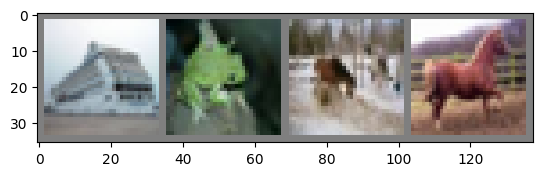

ship frog horse horse


In [6]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [12]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, bias=False)  # Свертка 3x3
        self.bn1 = nn.BatchNorm2d(32)  
        self.relu = nn.ReLU(inplace=True)  

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False)  # Свертка 3x3
        self.bn2 = nn.BatchNorm2d(32)

        self.shortcut = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1, bias=False)  # 1x1 Conv

        self.avgpool = nn.AvgPool2d(kernel_size=8) # Уменьшение размерности до 32x4x4
        
        # Полносвязный слой для логитов
        self.fc = nn.Linear(32 * 4 * 4, n_classes)

    def forward(self, x):
        shortcut = self.shortcut(x)  
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        out += shortcut
        out = self.relu(out)

        out = self.avgpool(out)

        out = out.view(out.size(0), -1)

        out = self.fc(out)

        return out

In [13]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [14]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [15]:
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [23]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = F.cross_entropy(output, target)
            
            pred = output.argmax(dim=1, keepdim=True)
            acc = pred.eq(target.view_as(pred)).sum().item() / data.size(0)
            
            loss_log.append(loss.item())
            acc_log.append(acc)
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / data.size(0)
        
        loss_log.append(loss.item())
        acc_log.append(acc)

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [24]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.5093610833724194, train acc: 0.46097218594933403
 val loss: 1.2930510470207701, val acc: 0.5455452127659575

Epoch 1
 train loss: 1.1824887863460798, train acc: 0.5844133585792635
 val loss: 1.1185754869846587, val acc: 0.6173093971631205

Epoch 2
 train loss: 1.072637157422751, train acc: 0.6279340232436668
 val loss: 1.0527802495246237, val acc: 0.6412455673758864

Epoch 3
 train loss: 1.0012443646434457, train acc: 0.6545850744319666
 val loss: 0.9838672432493656, val acc: 0.6580895390070923

Epoch 4
 train loss: 0.963359741449792, train acc: 0.666329328806477
 val loss: 1.0232839817696429, val acc: 0.6512854609929077

Epoch 5
 train loss: 0.9248752153769707, train acc: 0.6780490989814573
 val loss: 0.9605373083276951, val acc: 0.6671320921985816

Epoch 6
 train loss: 0.9000933619260352, train acc: 0.6890016975711674
 val loss: 0.9349188261843743, val acc: 0.6772384751773051

Epoch 7
 train loss: 0.8771650261591296, train acc: 0.6954696069469836
 val loss: 0.9

Посчитайте точность на тестовой выборке:

In [25]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

Test loss: 0.867728679802767, Test accuracy: 0.7074044585987261


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

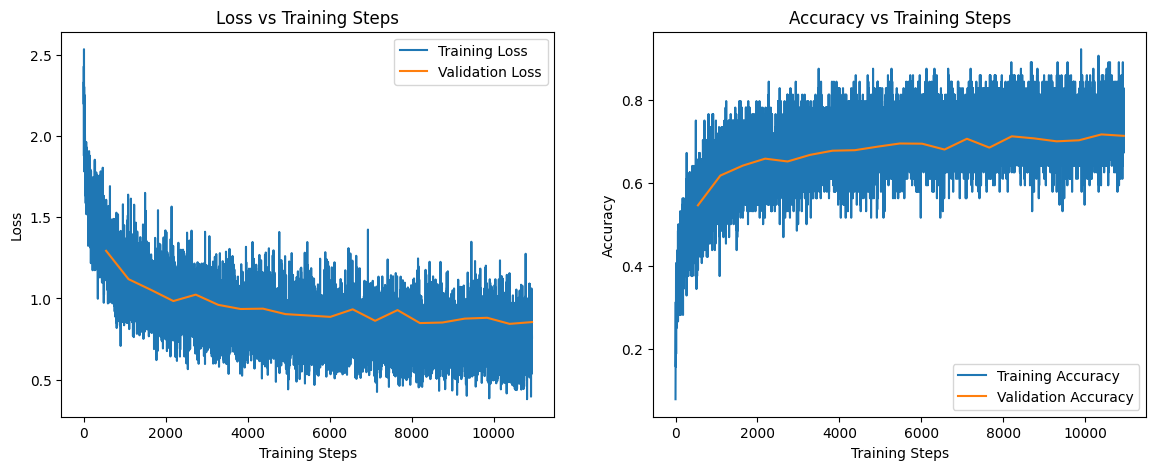

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_loss_log, label='Training Loss')
ax1.plot(np.arange(1, len(val_loss_log) + 1) * len(train_loader), val_loss_log, label='Validation Loss')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Training Steps')
ax1.legend()

ax2.plot(train_acc_log, label='Training Accuracy')
ax2.plot(np.arange(1, len(val_acc_log) + 1) * len(train_loader), val_acc_log, label='Validation Accuracy')
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Training Steps')
ax2.legend()

plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [27]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4893981373070362, train acc: 0.4702639396709324
 val loss: 1.2649833275916729, val acc: 0.5528812056737588

Epoch 1
 train loss: 1.1642338815511253, train acc: 0.5945130908853486
 val loss: 1.0855697025644018, val acc: 0.6175310283687944

Epoch 2
 train loss: 1.0529631332679903, train acc: 0.6332062875424392
 val loss: 1.0151872589233073, val acc: 0.6490691489361702

Epoch 3
 train loss: 0.9904031361260841, train acc: 0.6529609558631497
 val loss: 1.0269553828746714, val acc: 0.6432402482269503

Epoch 4
 train loss: 0.9532863677528702, train acc: 0.6669904021937842
 val loss: 0.9808121980504787, val acc: 0.6568040780141843

Epoch 5
 train loss: 0.9222879862000781, train acc: 0.6783143444763646
 val loss: 0.9220294323373348, val acc: 0.6816710992907801

Epoch 6
 train loss: 0.8916917546793574, train acc: 0.6905686863410813
 val loss: 0.9509268086007301, val acc: 0.6705008865248226

Epoch 7
 train loss: 0.874989539657258, train acc: 0.6939148602768347
 val loss: 0.

Посчитайте точность на тестовой выборке:

In [28]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

Test loss: 0.8220771325241988, Test accuracy: 0.7136743630573248


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [30]:
net_constant_lr = BasicBlockNet().to(device)
optimizer_constant_lr = optim.SGD(net_constant_lr.parameters(), lr=0.001, momentum=0.9)

train_loss_log_const_lr, train_acc_log_const_lr, val_loss_log_const_lr, val_acc_log_const_lr = train(
    net_constant_lr, optimizer_constant_lr, 20, train_loader, val_loader
)

test_loss_const_lr, test_acc_const_lr = test(net_constant_lr, test_loader)
print(f"Test loss with constant LR: {test_loss_const_lr}, Test accuracy with constant LR: {test_acc_const_lr}")

Epoch 0
 train loss: 1.8237326716156286, train acc: 0.36543483938365107
 val loss: 1.6010771715894658, val acc: 0.4454565602836879

Epoch 1
 train loss: 1.5232641577066843, train acc: 0.46763188822146773
 val loss: 1.434621540028998, val acc: 0.4963874113475177

Epoch 2
 train loss: 1.4095884197590773, train acc: 0.5082430138417341
 val loss: 1.3644094715727138, val acc: 0.5185948581560283

Epoch 3
 train loss: 1.3353289219753397, train acc: 0.533922858448681
 val loss: 1.297384651163791, val acc: 0.5474290780141843

Epoch 4
 train loss: 1.277578546643475, train acc: 0.5528899516845129
 val loss: 1.2550438883456778, val acc: 0.560793439716312

Epoch 5
 train loss: 1.2245600187582333, train acc: 0.5735668581875164
 val loss: 1.212185255517351, val acc: 0.576706560283688

Epoch 6
 train loss: 1.1787226914923632, train acc: 0.589885577174197
 val loss: 1.1720219074411595, val acc: 0.5886524822695035

Epoch 7
 train loss: 1.1404577508922904, train acc: 0.6042006724993472
 val loss: 1.12114

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
net_steplr = BasicBlockNet().to(device)
optimizer_steplr = optim.SGD(net_steplr.parameters(), lr=0.1, momentum=0.9)
scheduler_steplr = optim.lr_scheduler.StepLR(optimizer_steplr, step_size=10, gamma=0.1)

train_loss_log_steplr, train_acc_log_steplr, val_loss_log_steplr, val_acc_log_steplr = train(
    net_steplr, optimizer_steplr, 20, train_loader, val_loader, scheduler_steplr
)

test_loss_steplr, test_acc_steplr = test(net_steplr, test_loader)
print(f"Test loss with StepLR: {test_loss_steplr}, Test accuracy with StepLR: {test_acc_steplr}")

# lr_scheduler.ExponentialLR - Decays the learning rate of each parameter group by gamma every epoch (взял прост с доки торча, надеюсь сойдет)) )
net_explr = BasicBlockNet().to(device)
optimizer_explr = optim.SGD(net_explr.parameters(), lr=0.1, momentum=0.9)
scheduler_explr = optim.lr_scheduler.ExponentialLR(optimizer_explr, gamma=0.9)

train_loss_log_explr, train_acc_log_explr, val_loss_log_explr, val_acc_log_explr = train(
    net_explr, optimizer_explr, 20, train_loader, val_loader, scheduler_explr
)

test_loss_explr, test_acc_explr = test(net_explr, test_loader)
print(f"Test loss with ExponentialLR: {test_loss_explr}, Test accuracy with ExponentialLR: {test_acc_explr}")

# lr_scheduler.ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.(так же с торча)
net_plateau = BasicBlockNet().to(device)
optimizer_plateau = optim.SGD(net_plateau.parameters(), lr=0.1, momentum=0.9)
scheduler_plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer_plateau, mode='min', factor=0.1, patience=5, verbose=True)

train_loss_log_plateau, train_acc_log_plateau, val_loss_log_plateau, val_acc_log_plateau = train(
    net_plateau, optimizer_plateau, 20, train_loader, val_loader
)

for val_loss in val_loss_log_plateau:
    scheduler_plateau.step(val_loss)

test_loss_plateau, test_acc_plateau = test(net_plateau, test_loader)
print(f"Test loss with ReduceLROnPlateau: {test_loss_plateau}, Test accuracy with ReduceLROnPlateau: {test_acc_plateau}")

Epoch 0
 train loss: 1.4638162285797776, train acc: 0.48062483677200313
 val loss: 1.2315744810916007, val acc: 0.5679742907801417

Epoch 1
 train loss: 1.1721936791209024, train acc: 0.5893101984852441
 val loss: 1.1352379486915913, val acc: 0.6061835106382979

Epoch 2
 train loss: 1.06724854165065, train acc: 0.6277748759467223
 val loss: 1.0239929929692695, val acc: 0.6424202127659574

Epoch 3
 train loss: 1.0013592043785988, train acc: 0.649067968137895
 val loss: 1.0397335640927579, val acc: 0.6346631205673758

Epoch 4
 train loss: 0.9650220293449527, train acc: 0.6650479890310786
 val loss: 0.974815205817527, val acc: 0.667154255319149

Epoch 5
 train loss: 0.9276030600833719, train acc: 0.6804607926351528
 val loss: 0.9656876317998196, val acc: 0.6647606382978724

Epoch 6
 train loss: 0.9022104075447515, train acc: 0.686904217811439
 val loss: 0.9179279388265407, val acc: 0.6848182624113476

Epoch 7
 train loss: 0.8864315339590557, train acc: 0.6931884956907808
 val loss: 0.9357

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0
 train loss: 1.4977120653584846, train acc: 0.4668035061373727
 val loss: 1.3119767861163363, val acc: 0.5387189716312056

Epoch 1
 train loss: 1.2249328745784445, train acc: 0.5695269652650823
 val loss: 1.1414532156700783, val acc: 0.5978501773049646

Epoch 2
 train loss: 1.0877516129117126, train acc: 0.6207397492817969
 val loss: 1.0406304037317318, val acc: 0.6337101063829788

Epoch 3
 train loss: 1.0150693815194711, train acc: 0.6464848850874901
 val loss: 1.0349352978645487, val acc: 0.6456560283687944

Epoch 4
 train loss: 0.9731190162123449, train acc: 0.6610080961086445
 val loss: 0.9752743771735658, val acc: 0.6651374113475178

Epoch 5
 train loss: 0.9416919188264083, train acc: 0.6732134695743014
 val loss: 0.9913430645110759, val acc: 0.6611923758865248

Epoch 6
 train loss: 0.9112425089100379, train acc: 0.6854351658396448
 val loss: 1.0305791677312648, val acc: 0.6512189716312056

Epoch 7
 train loss: 0.9025813565066789, train acc: 0.6869939932097153
 val loss: 1

Your answers here: Test loss with StepLR: 0.8329180725820505, Test accuracy with StepLR: 0.7138734076433121
Test loss with ReduceLROnPlateau: 0.8777586905060301, Test accuracy with ReduceLROnPlateau: 0.7005374203821656
Test loss with ExponentialLR: 0.8265286930807078, Test accuracy with ExponentialLR: 0.7157643312101911

Как видим лучшие показатели у экспоненцального и нам чуть чуть удалось добиться качества лучше чем у конст. Кратко как работают- exp уменьшает лр экспонценально каждую эпоху (задаем гамму 0,9 -> умненьшание будет на 10 проц), а редьюсьдлинноеслово уменьшает шаг в случае если после каких то n эпох наша метрика не начинает улучшаться и шаг уменьшается в заданное количество раз(фактор назыв)


## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

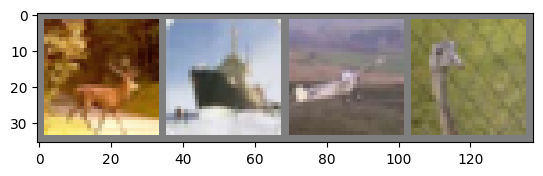

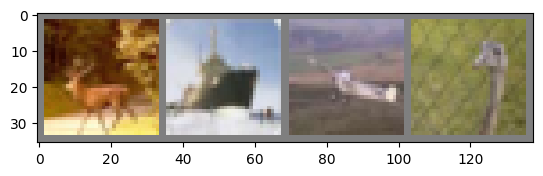

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4987020217958273, train acc: 0.46655866414207364
 val loss: 1.3139872452046009, val acc: 0.5411347517730497

Epoch 1
 train loss: 1.2023060383918733, train acc: 0.5789207364847219
 val loss: 1.1796782052263302, val acc: 0.5886081560283689

Epoch 2
 train loss: 1.0738919953759454, train acc: 0.6268893640637242
 val loss: 1.1203982208637482, val acc: 0.6037012411347519

Epoch 3
 train loss: 1.0232563190965809, train acc: 0.6463094149908593
 val loss: 0.9797822424705992, val acc: 0.6589760638297872

Epoch 4
 train loss: 0.9799560689838974, train acc: 0.6586902585531471
 val loss: 0.9795198341633411, val acc: 0.6581781914893617

Epoch 5
 train loss: 0.949918725045987, train acc: 0.6716587229041525
 val loss: 0.9630310512603597, val acc: 0.6720301418439716

Epoch 6
 train loss: 0.9252788812412422, train acc: 0.6801588208409507
 val loss: 0.9898649205552771, val acc: 0.6611480496453902

Epoch 7

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

Test loss: 0.8161260827331785, Test accuracy: 0.716062898089172


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [34]:
transform_color_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_resized_crop = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_grayscale = transforms.Compose([
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def train_and_test_with_transform(transform):
    train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)
    
    net = BasicBlockNet().to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
    
    train(net, optimizer, 20, train_loader, val_loader, scheduler)
    
    test_loss, test_acc = test(net, test_loader)
    print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")
    return test_loss, test_acc

print("Training with ColorJitter:")
train_and_test_with_transform(transform_color_jitter)

print("Training with RandomResizedCrop:")
train_and_test_with_transform(transform_resized_crop)

print("Training with RandomGrayScale:")
train_and_test_with_transform(transform_grayscale)

Training with ColorJitter:
Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.560358417099529, train acc: 0.44632247323060853
 val loss: 1.3346823469121405, val acc: 0.5336879432624113

Epoch 1
 train loss: 1.2567960080542555, train acc: 0.5631855575868373
 val loss: 1.227210164577403, val acc: 0.5730274822695035

Epoch 2
 train loss: 1.1412635980620027, train acc: 0.6046087424915121
 val loss: 1.1726494773905327, val acc: 0.5910460992907801

Epoch 3
 train loss: 1.0866197530704618, train acc: 0.6242695547140246
 val loss: 1.1017236833876751, val acc: 0.6234929078014183

Epoch 4
 train loss: 1.0439824808450242, train acc: 0.6421552624706189
 val loss: 1.12214465724661, val acc: 0.6012632978723405

Epoch 5
 train loss: 1.0158333300018658, train acc: 0.649675992426221
 val loss: 1.0814553859386038, val acc: 0.6335771276595744

Epoch 6
 train loss: 0.9840689517244342, train acc: 0.6584821428571428
 val loss: 1.0505794289264274, val acc: 0.63

(np.float64(0.8166476214767262), np.float64(0.7135748407643312))

Test loss: 0.8484945270665891, Test accuracy: 0.7080015923566879 - ColorJitter


Test loss: 0.8976063249976771, Test accuracy: 0.6952627388535032 - RandomResizedCrop


Test loss: 0.8166476214767262, Test accuracy: 0.7135748407643312- RandomGrayScale


Test loss: 0.8161260827331785, Test accuracy: 0.716062898089172 - RandomHorizontalFlip(то что было уже написано авторами дз)


Видно что добиться качество лучше не удалось, мб если бы я выбрал другой трансформер из списка торча, то мы бы побили качество, но что есть то есть




colorjitter - прост изменяет яркость, насыщенность и прочее(параметры можно глянуть на торче, они все задаются каким то процентом и меняются, например контраст=0.2 значит контраст изменится случайно в пределах 20 проц). зачем? чтобы модель не упала в обморок если на вход пойдут картинки с чуть другим освещением.



randomresizedcrop - вырезает случайно кусок имаджа и изменяет размер до заданного(параметры до какого размера изменить и scale=(что то, что то) который определяет диапазон который мы выразаем.) зачем? чтобы модель не упала в обморок при виде изображения с чуть другой стороны или если картинка маленькая какая то.


randomgrayscale - просто с какой то заданной вероятностью делает картинку серой. зачем? чтобы могли понять что это например наша картинка но просто не цветная.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [1]:
%pip install wandb


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [20]:
import wandb

wandb.init(project="cifar10-classification")

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

wandb.watch(net, log="all")

def train_epoch_wandb(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / data.size(0)
        
        loss_log.append(loss.item())
        acc_log.append(acc)

        wandb.log({"train_loss": loss.item(), "train_accuracy": acc})

    return loss_log, acc_log

def train_wandb(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch_wandb(model, optimizer, train_loader)
        val_loss, val_acc = test_wandb(model, val_loader, phase="validation")
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        wandb.log({
            "epoch": epoch,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

def test_wandb(model, loader, phase="test"):
    loss_log = []
    acc_log = []
    model.eval()
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = F.cross_entropy(output, target)
            
            pred = output.argmax(dim=1, keepdim=True)
            acc = pred.eq(target.view_as(pred)).sum().item() / data.size(0)
            
            loss_log.append(loss.item())
            acc_log.append(acc)
        
    wandb.log({
        f"{phase}_loss": np.mean(loss_log),
        f"{phase}_accuracy": np.mean(acc_log)
    })
    
    return np.mean(loss_log), np.mean(acc_log)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train_wandb(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss, test_acc = test_wandb(net, test_loader, phase="test")
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

wandb.finish()


train_accuracy,▁▃▅▄▅▆▅▅▇▅▆▄▅▆▆▆▄▅▅▆▅▅▆▆▇▆▆▄▆▆▅▆▆▇█▆▆▆▅▆
train_loss,█▇▇▅▅▄▅▅▄▃▅▅▃▅▅▃▅▅▃▄▃▅▃▂▂▂▃▄▃▃▁▄▂▂▂▃▂▂▂▂
train_accuracy,0.51786
train_loss,1.24827


Epoch 0
 train loss: 1.5014866538195986, train acc: 0.4629064377121964
 val loss: 1.2863262173977303, val acc: 0.5460771276595745

Epoch 1
 train loss: 1.1828200946778222, train acc: 0.5842460498824759
 val loss: 1.074185283386961, val acc: 0.6223182624113476

Epoch 2
 train loss: 1.0635030360064952, train acc: 0.6269995429616088
 val loss: 1.0494761362988898, val acc: 0.6368351063829787

Epoch 3
 train loss: 0.9981763954572311, train acc: 0.6522958017759206
 val loss: 1.0073553810728357, val acc: 0.651706560283688

Epoch 4
 train loss: 0.9582413749895322, train acc: 0.6669128688952729
 val loss: 0.9670232055035043, val acc: 0.6657579787234043

Epoch 5
 train loss: 0.9287615432599781, train acc: 0.6759475385218072
 val loss: 0.9797415428973258, val acc: 0.6570700354609929

Epoch 6
 train loss: 0.9123326954610604, train acc: 0.6820073779054584
 val loss: 0.9350078225135803, val acc: 0.6751773049645391

Epoch 7
 train loss: 0.883407933184608, train acc: 0.694110733873074
 val loss: 0.921

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▃▃▄▅▄▄▅▄▆▅▁▄█▃▅▆▄█▃█▆▆▂▇▄▆▅██▅▆▅▆▆▇▆▆▇
train_loss,██▆▆▅▅▃▆▄▄▄▄▄▅▂▃▅▄▃▄▂▃▄▄▃▃▃▂▂▃▂▂▂▃▃▂▁▂▂▁
val_accuracy,▁▄▅▅▆▅▆▆▅▆██████████
val_loss,█▅▅▄▃▄▃▃▃▃▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▅▆▅▆▆▅▆██████████
validation_loss,█▅▅▄▃▄▃▃▃▃▁▁▁▁▁▁▁▁▁▁
epoch,19
test_accuracy,0.71935


**У меня почему то не вышло дать линк на эту тему, поэтому я сохранил пнг графиков. Если что можно написать в лс @warning172 за доп графиками (если вдруг какие то нужны будут а я упустил)**

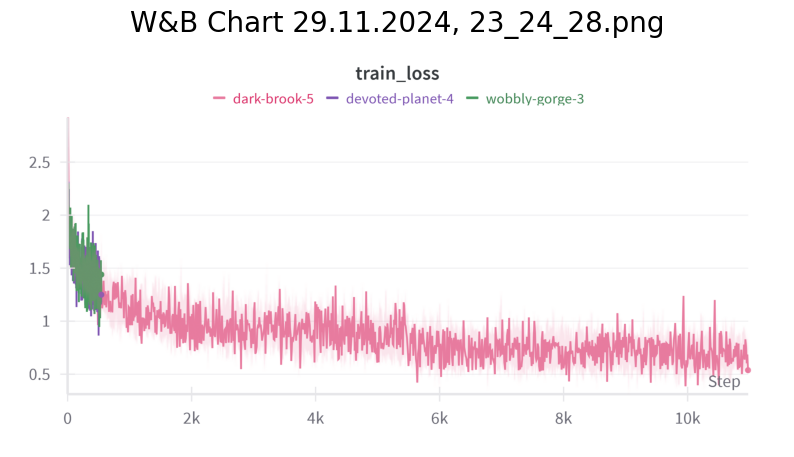

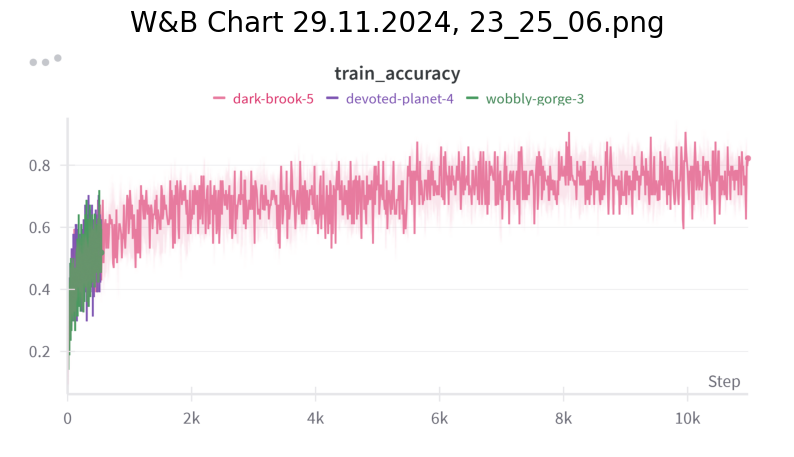

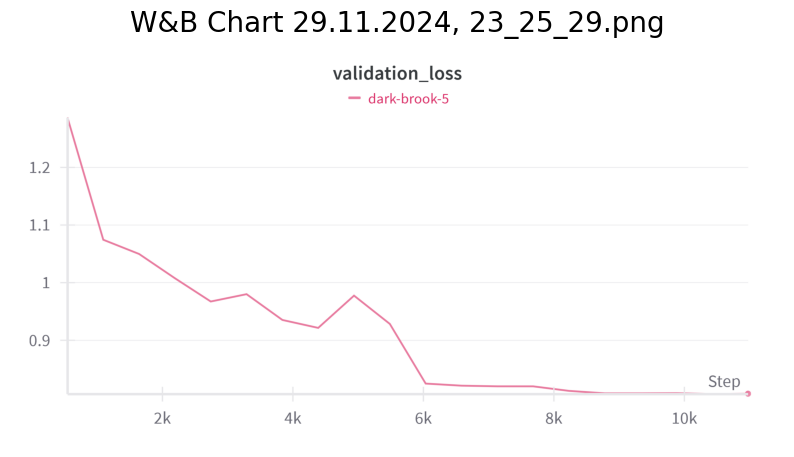

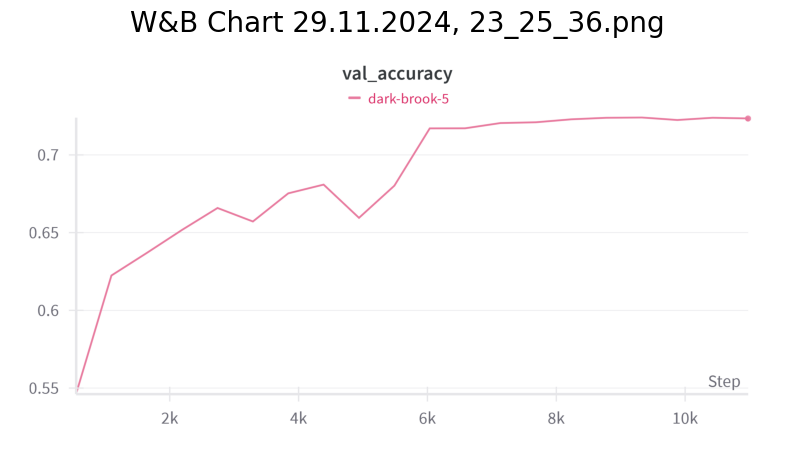

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

folder_path = 'C:\\Users\\1\\vscode-projects\\dl-hse\\hw2'
files = os.listdir(folder_path)

png_files = [file for file in files if file.endswith('.png')]
png_files = png_files[:4]

for i, png_file in enumerate(png_files):
    img = mpimg.imread(os.path.join(folder_path, png_file))
    
    plt.figure(figsize=(10, 10))  
    plt.imshow(img)
    plt.title(png_file, fontsize=20) 
    plt.axis('off') 
    plt.show()
